In [18]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

import utils as ut
import pickle
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf

In [16]:
# Hyperparameters
MAX_SEQUENCE_LENGTH = 128
EMBEDDING_DIM = 512
LSTM_UNITS = 256
DENSE_UNITS = 128
EPOCHS = 4
BATCH_SIZE = 256
TEST_SIZE = 0.3
LEARNING_RATE = 0.01
DROPOUT_RATE = 0.2

In [11]:

def load_tokenizer(tokenizer_file_path='tokenizer.pkl'):
    with open(tokenizer_file_path, 'rb') as tokenizer_file:
        tokenizer = pickle.load(tokenizer_file)
    return tokenizer

def load_label_encoder(label_encoder_file_path='label_encoder.pkl'):
    with open(label_encoder_file_path, 'rb') as label_encoder_file:
        label_encoder = pickle.load(label_encoder_file)
    return label_encoder

def load_data():
    # Load CSV data
    df = pd.read_csv("random_samples.csv")

    # Encode datatypes
    label_encoder = LabelEncoder()
    df['datatype_encoded'] = label_encoder.fit_transform(df['datatype'])

    # Tokenize and pad sequences
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(df['ops_funcs'])
    sequences = tokenizer.texts_to_sequences(df['ops_funcs'])
    padded_sequences = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)

    return df, tokenizer, padded_sequences, label_encoder


In [12]:

def build_model(df, tokenizer, padded_sequences, label_encoder, learning_rate=LEARNING_RATE):
    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(padded_sequences, df['datatype_encoded'], test_size=TEST_SIZE, random_state=42)

    # Build LSTM model with bidirectional layers
    model = Sequential()
    model.add(Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=EMBEDDING_DIM, input_length=padded_sequences.shape[1]))

    model.add(Bidirectional(LSTM(units=LSTM_UNITS, return_sequences=True)))
    model.add(Dropout(rate=DROPOUT_RATE))
    
    model.add(Bidirectional(LSTM(units=LSTM_UNITS//2, return_sequences=True)))
    model.add(Dropout(rate=DROPOUT_RATE))
    
    model.add(Bidirectional(LSTM(units=LSTM_UNITS//4)))
    model.add(Dropout(rate=DROPOUT_RATE))
    
    model.add(Dense(units=len(label_encoder.classes_), activation='softmax'))


    # Compile the model
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    # Print model architecture
    tf.keras.utils.plot_model(model, to_file='lstm_model.png', show_shapes=True, dpi=64)

    return model, X_train, y_train, X_test, y_test



In [13]:
def fit_model(model, X_train, y_train, X_test, y_test):
    # Train the model
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    model.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data=(X_test, y_test), callbacks=[early_stopping])

    # Evaluate the model
    loss, accuracy = model.evaluate(X_test, y_test)
    ut.print_info(f'[TEST] Accuracy: {accuracy * 100:.2f}%')

    # Get predictions
    predictions = model.predict(X_test)

    return loss, accuracy, predictions


In [19]:
def train():
    # Load data
    df, tokenizer, padded_sequences, label_encoder = load_data()

    # Save tokenizer
    with open('tokenizer.pkl', 'wb') as tokenizer_file:
        pickle.dump(tokenizer, tokenizer_file)

    # Save label encoder
    with open('label_encoder.pkl', 'wb') as label_encoder_file:
        pickle.dump(label_encoder, label_encoder_file)

    # Build model
    model, X_train, y_train, X_test, y_test = build_model(df, tokenizer, padded_sequences, label_encoder)

    # Train and evaluate model
    loss, accuracy, predictions = fit_model(model, X_train, y_train, X_test, y_test)

    # Save model to h5 file
    model.save('classifier.h5')

    # Obtain confusion matrix and classification report
    y_pred = predictions.argmax(axis=1)
    y_true = y_test

    cm = confusion_matrix(y_true, y_pred)
    cr = classification_report(y_true, y_pred)

    # Display confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

    print("Classification Report:\n", cr)

    return loss, accuracy


Epoch 1/4
6/6 [==============================] - 151s 22s/step - loss: 1.7392 - accuracy: 0.3093 - val_loss: 1.1124 - val_accuracy: 0.7667
Epoch 2/4
6/6 [==============================] - 130s 22s/step - loss: 0.7808 - accuracy: 0.7421 - val_loss: 0.4927 - val_accuracy: 0.7700
Epoch 3/4
6/6 [==============================] - 129s 22s/step - loss: 0.3753 - accuracy: 0.8529 - val_loss: 0.4749 - val_accuracy: 0.9633
Epoch 4/4
19/19 [==============================] - 28s 1s/step - loss: 0.1690 - accuracy: 0.9550
│[INFO] [TEST] Accuracy: 95.50%
19/19 [==============================] - 25s 1s/step


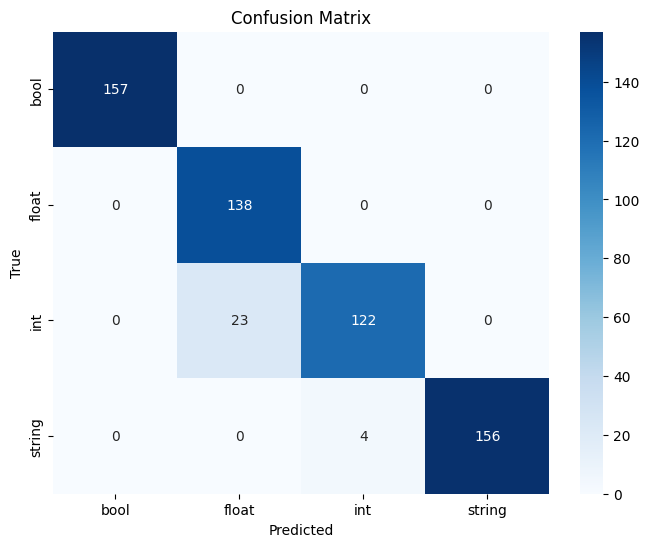

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       157
           1       0.86      1.00      0.92       138
           2       0.97      0.84      0.90       145
           3       1.00      0.97      0.99       160

    accuracy                           0.95       600
   macro avg       0.96      0.95      0.95       600
weighted avg       0.96      0.95      0.95       600



In [20]:
# Call the train function
loss, accuracy = train()